#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 合成特征和离群值

 **学习目标：**
  * 创建一个合成特征，即另外两个特征的比例
  * 将此新特征用作线性回归模型的输入
  * 通过识别和截取（移除）输入数据中的离群值来提高模型的有效性

 我们来回顾下之前的“使用 TensorFlow 的基本步骤”练习中的模型。

首先，我们将加利福尼亚州住房数据导入 *Pandas* `DataFrame` 中：

 ## 设置

In [41]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
13391,-121.9,38.0,18.0,2541.0,355.0,986.0,346.0,7.2,288.0
6321,-118.2,33.9,44.0,1137.0,235.0,747.0,225.0,2.0,92.6
11586,-121.3,38.6,22.0,2938.0,619.0,1501.0,561.0,2.7,96.1
9441,-119.2,35.8,35.0,1618.0,378.0,1449.0,398.0,1.7,56.5
10878,-120.8,37.5,30.0,1340.0,244.0,631.0,231.0,3.4,118.5
...,...,...,...,...,...,...,...,...,...
6098,-118.2,34.1,40.0,2124.0,370.0,998.0,372.0,5.3,370.4
14001,-122.0,37.3,23.0,2590.0,725.0,1795.0,680.0,3.2,225.0
14131,-122.1,37.9,43.0,1454.0,234.0,683.0,258.0,4.5,265.7
8198,-118.4,34.2,35.0,2344.0,435.0,1531.0,399.0,3.7,178.2


 接下来，我们将设置输入函数，并针对模型训练来定义该函数：

In [2]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [3]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

 ## 任务 1：尝试合成特征

`total_rooms` 和 `population` 特征都会统计指定街区的相关总计数据。

但是，如果一个街区比另一个街区的人口更密集，会怎么样？我们可以创建一个合成特征（即 `total_rooms` 与 `population` 的比例）来探索街区人口密度与房屋价值中位数之间的关系。

在以下单元格中，创建一个名为 `rooms_per_person` 的特征，并将其用作 `train_model()` 的 `input_feature`。

通过调整学习速率，您使用这一特征可以获得的最佳效果是什么？（效果越好，回归线与数据的拟合度就越高，最终 RMSE 也会越低。）

 **注意**：在下面添加一些代码单元格可能有帮助，这样您就可以尝试几种不同的学习速率并比较结果。要添加新的代码单元格，请将光标悬停在该单元格中心的正下方，然后点击**代码**。

646     2.9
14977   2.6
10441   1.2
2557    2.4
10409   9.3
         ..
5425    1.8
11207   1.9
8821    1.8
9175    2.3
7069    0.9
Name: rooms_per_person, Length: 17000, dtype: float64
Training model...
RMSE (on training data):
  period 00 : 213.73
  period 01 : 192.13
  period 02 : 171.94
  period 03 : 154.75
  period 04 : 142.87
  period 05 : 134.18
  period 06 : 131.73
  period 07 : 130.79
  period 08 : 130.71
  period 09 : 130.81
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,188.8,207.3
std,86.4,116.0
min,43.7,15.0
25%,154.9,119.4
50%,185.9,180.4
75%,212.2,265.0
max,4124.3,500.0


Final RMSE (on training data): 130.81


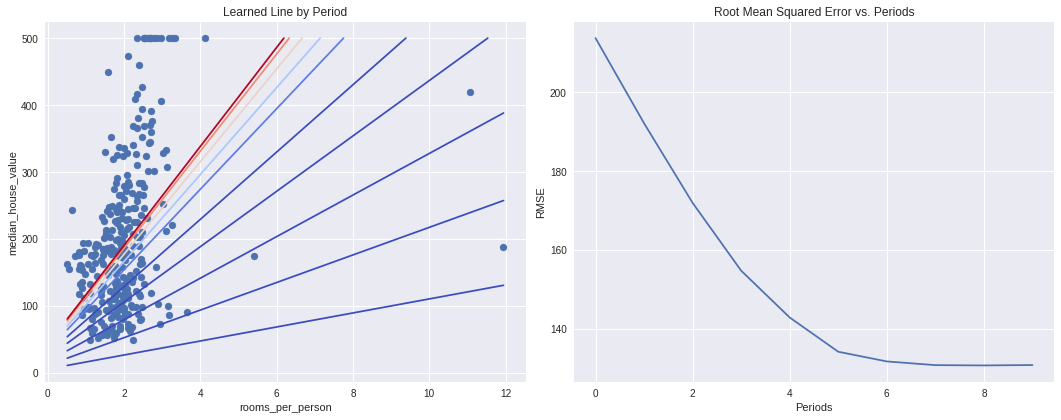

In [19]:
#
# YOUR CODE HERE
#
california_housing_dataframe["rooms_per_person"] =(california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
print(california_housing_dataframe["rooms_per_person"])
calibration_data = train_model(
    learning_rate=0.05,
    steps=550,
    batch_size=3,
    input_feature="rooms_per_person"
)

 ### 解决方案

点击下方即可查看解决方案。

Training model...
RMSE (on training data):
  period 00 : 212.78
  period 01 : 189.68
  period 02 : 169.56
  period 03 : 154.59
  period 04 : 141.53
  period 05 : 133.69
  period 06 : 131.27
  period 07 : 130.97
  period 08 : 131.34
  period 09 : 132.04
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,197.4,207.3
std,90.8,116.0
min,45.0,15.0
25%,161.8,119.4
50%,194.4,180.4
75%,222.0,265.0
max,4332.2,500.0


Final RMSE (on training data): 132.04


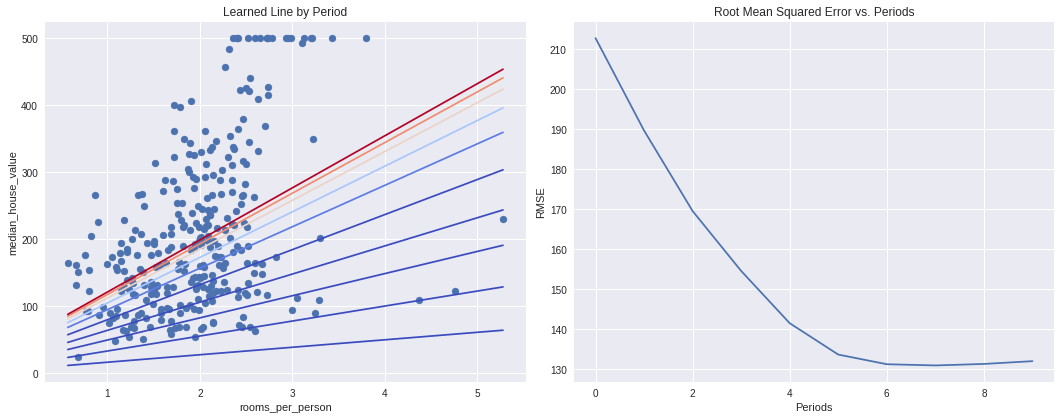

In [25]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

 ## 任务 2：识别离群值

我们可以通过创建预测值与目标值的散点图来可视化模型效果。理想情况下，这些值将位于一条完全相关的对角线上。

使用您在任务 1 中训练过的人均房间数模型，并使用 Pyplot 的 `scatter()` 创建预测值与目标值的散点图。

您是否看到任何异常情况？通过查看 `rooms_per_person` 中值的分布情况，将这些异常情况追溯到源数据。

In [0]:
# YOUR CODE HERE

 ### 解决方案

点击下方即可查看解决方案。

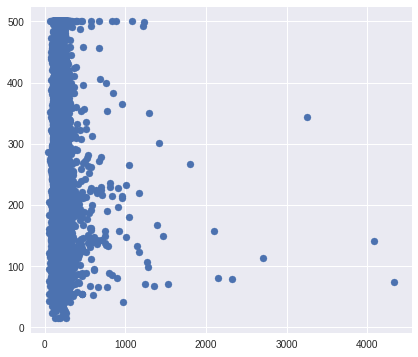

In [26]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

 校准数据显示，大多数散点与一条线对齐。这条线几乎是垂直的，我们稍后再讲解。现在，我们重点关注偏离这条线的点。我们注意到这些点的数量相对较少。

如果我们绘制 `rooms_per_person` 的直方图，则会发现我们的输入数据中有少量离群值：

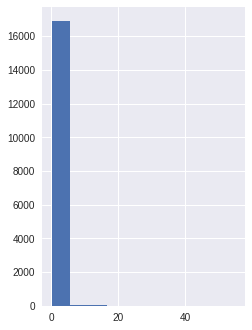

In [27]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

 ## 任务 3：截取离群值

看看您能否通过将 `rooms_per_person` 的离群值设置为相对合理的最小值或最大值来进一步改进模型拟合情况。

以下是一个如何将函数应用于 Pandas `Series` 的简单示例，供您参考：

    clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))

上述 `clipped_feature` 没有小于 `0` 的值。

In [0]:
# YOUR CODE HERE

 ### 解决方案

点击下方即可查看解决方案。

 我们在任务 2 中创建的直方图显示，大多数值都小于 `5`。我们将 `rooms_per_person` 的值截取为 5，然后绘制直方图以再次检查结果。

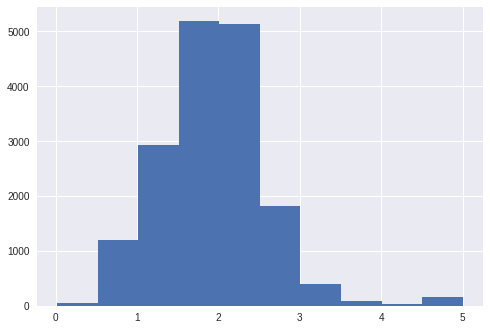

In [28]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

 为了验证截取是否有效，我们再训练一次模型，并再次输出校准数据：

Training model...
RMSE (on training data):
  period 00 : 203.23
  period 01 : 171.14
  period 02 : 144.34
  period 03 : 126.27
  period 04 : 118.24
  period 05 : 113.82
  period 06 : 110.06
  period 07 : 108.62
  period 08 : 108.18
  period 09 : 107.80
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,201.4,207.3
std,52.0,116.0
min,48.9,15.0
25%,168.2,119.4
50%,201.4,180.4
75%,229.7,265.0
max,444.0,500.0


Final RMSE (on training data): 107.80


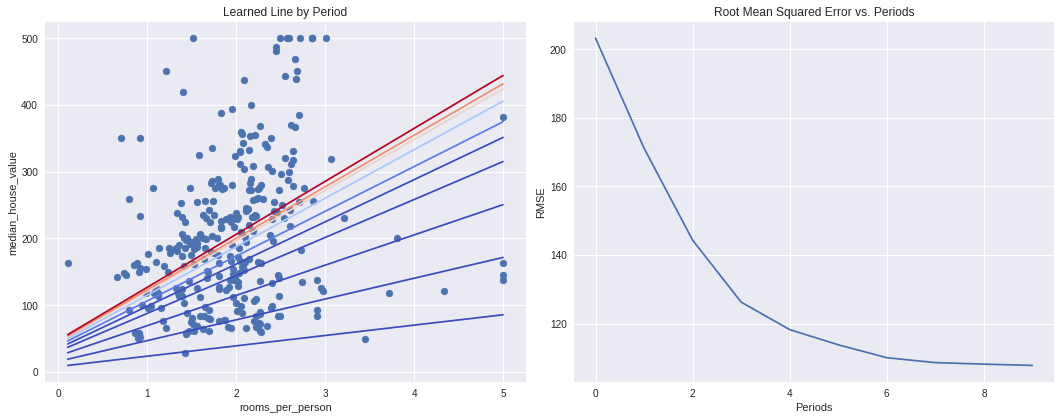

In [39]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=700,
    batch_size=3,
    input_feature="rooms_per_person")

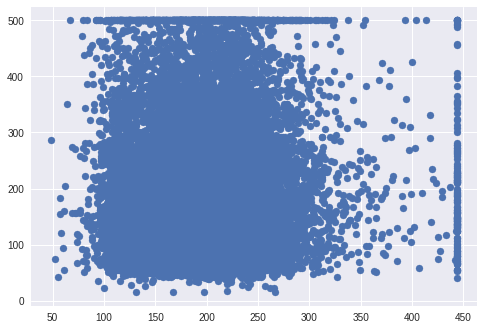

In [40]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])